In [ ]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import pickle
from google.colab import drive

drive.mount('/content/gdrive')
path_to_data = '/content/gdrive/My Drive/University/Year 4/CSC413/Project/data.pickle'

!pip install pretty_midi
!cp "/content/gdrive/My Drive/University/Year 4/CSC413/Project/data_parser.py" .

from data_parser import create_midi_file


Mounted at /content/gdrive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 44.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 KB 4.2 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592303 sha256=21405bb28c8e18cae44cb72714035bddff422e25ae9a59bf24940b2f1bc99f01
  Stored in directory: /root/.cache/pip/wheels/75/ec/20/b8e937a5bcf1de547ea5ce465db7de7f6761e15e6f0a01e25f
Successfully built pretty_midi


# **Model**

In [ ]:
class MusicGenRNN(nn.Module):
  def __init__(self, hidden_size = 512, num_rnn_layers = 1, bias_rnn = True, pitch_embedding_size=130):
    super(MusicGenRNN, self).__init__()
    # pitch_vocab_size = number of notes possible + begin sequence token
    self.pitch_vocab_size = 128 + 1
    # to turn pitch to one hots
    self.ident = torch.eye(self.pitch_vocab_size).to(device)

    # number of units in RNN encoder
    self.hidden_size = hidden_size
    
    # embedding size for pitch, to turn one hots to continous vectors
    self.pitch_embedding_size = pitch_embedding_size
    self.pitch_embedding_layer = nn.Linear(self.pitch_vocab_size, self.pitch_embedding_size, bias=False)
    
    # LSTM params nn.LSTM(input_size, hidden_size, num_layers, bias, batch_first=True, dropout)
    # add two to embedding size to account for step and duration
    self.rnn = nn.LSTM(self.pitch_embedding_size + 2, hidden_size, num_rnn_layers, bias=bias_rnn, batch_first=True, dropout=0)
    
    # decoders to get distributions and values for pitch, step and duration
    # went with 300 here as it is in between deafult 512 and pitch_vocab_size
    self.decoder_pitch1 = nn.Linear(hidden_size, 300)
    self.decoder_pitch2 = nn.Linear(300, self.pitch_vocab_size)

    # step and duration decoders
    self.decoder_step = nn.Linear(hidden_size, 1)
    self.decoder_duration = nn.Linear(hidden_size, 1)


  def forward(self, input, hidden_in=None):
    # parse input
    pitch_in = input[:, :, 0].long()
    step_in = input[:, :, 1]
    dur_in = input[:, :, 2]
    # embed pitch
    pitch_one_hot = self.ident[pitch_in]
    pitch_emb = self.pitch_embedding_layer(pitch_one_hot)
    # join everything back together to encode it
    inp = torch.concat((pitch_emb, step_in.unsqueeze(2), dur_in.unsqueeze(2)), dim=2)
    output, hidden_out = self.rnn(inp, hidden_in) 
    # decoder everything
    out_pitch = self.decoder_pitch2(torch.relu(self.decoder_pitch1(output)))  
    out_step = self.decoder_step(output)
    out_dur = self.decoder_duration(output)

    return torch.concat((out_pitch, out_step, out_dur), dim=2), hidden_out

# **Loading Data**

In [ ]:
with open(path_to_data, 'rb') as f:
    dataset = pickle.load(f)

train_set, validation_set, test_set = dataset

print(train_set.shape)

(3603, 64, 3)


# **Training**

In [ ]:
train_distros = []
valid_distros = []

def train(model, device, train_data, valid_data, batch_size=32, weight_decay=0.0,
           learning_rate=0.001, num_epochs=7, checkpoint_path=None):
  # get loss function, CE has softmax built in
  criterion_pitch = nn.CrossEntropyLoss()
  # criterion_step = nn.MSELoss()
  # criterion_dur = nn.MSELoss()
  criterion_step = nn.L1Loss()
  criterion_dur = nn.L1Loss()

  # get optimizer
  optimizer = optim.Adam(model.parameters(),
                          lr=learning_rate,
                          weight_decay=weight_decay)
  
  # get dataloader, load training data, and validation data
  train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle=True)
  validation_loader = torch.utils.data.DataLoader(valid_data,
                                               batch_size=batch_size,
                                               shuffle=True)
  
  # learning curve information for plotting
  train_iters_list, losses_training, iter_at_epoch, train_acc, val_acc = [], [], [], [], []
  valid_iters_list, losses_validation =  [], []
  num_iters_train, num_iters_valid = 0, 0

  # iterate the given number of epochs
  for epoch in range(num_epochs):
    # shuffling data done automatically by data loader
    for batch_of_sequences in iter(train_loader): # iterate through all data in train loader
    # batch_of_sequences is of batch size
      # account for smaller last batch
      if batch_of_sequences.size()[0] < batch_size:
        continue

      # compute forward and backward pass
      model.train() # ensure model in train mode

      # add <BOS>=128, pitch values range 0-127 inclusive
      BOS = torch.tensor([128, 0.0, 0.0] * batch_size).reshape(batch_size, 1, 3)
      input = torch.concat((BOS, batch_of_sequences), dim=1).to(device)
      # only go up to second last input as last one is just predicted never fed in
      input = input[:, :-1, :] 
      out, _ = model(input.float())
      out_pitch = out[:, :, :129]
      out_step = out[:, :, 129]
      out_dur = out[:, :, 130]

      targets = batch_of_sequences.float().to(device)
      targets_pitch = targets[:, :, 0].long()
      targets_step = targets[:, :, 1]
      targets_dur = targets[:, :, 2]
      
      # compute losses
      loss_pitch = criterion_pitch(out_pitch.reshape(-1, model.pitch_vocab_size), targets_pitch.reshape(-1).long())
      loss_step = criterion_step(out_step, targets_step)
      loss_dur = criterion_dur(out_dur, targets_dur)
      total_loss = loss_step + loss_dur + loss_pitch
      # go backward/grad descent
      total_loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      
      # gather plotting data
      num_iters_train += 1
      losses_training.append(float(loss_pitch.item() + loss_step.item() + loss_dur.item()))
      train_iters_list.append(num_iters_train)

  
    # iterate through all data in valid loader
    for batch_of_sequences in iter(validation_loader): 
      # batch_of_sequences is of batch size
        # account for smaller last batch
        if batch_of_sequences.size()[0] < batch_size:
          continue
        # compute forward and backward pass
        model.eval() # ensure model in eval mode, no decent here just trying to gain accuarcy

        # add <BOS>=128, pitch values range 0-127 inclusive
        BOS = torch.tensor([128, 0.0, 0.0] * batch_size).reshape(batch_size, 1, 3)
        input = torch.concat((BOS, batch_of_sequences), dim=1).to(device)
        # only go up to second last input as last one is just predicted never fed in
        input = input[:, :-1, :] 
        out, _ = model(input.float())
        out_pitch = out[:, :, :129]
        out_step = out[:, :, 129]
        out_dur = out[:, :, 130]

        targets = batch_of_sequences.float().to(device)
        targets_pitch = targets[:, :, 0].long()
        targets_step = targets[:, :, 1]
        targets_dur = targets[:, :, 2]
        
        # compute losses
        loss_pitch_v = criterion_pitch(out_pitch.reshape(-1, model.pitch_vocab_size), targets_pitch.reshape(-1).long())
        loss_step_v = criterion_step(out_step, targets_step)
        loss_dur_v = criterion_dur(out_dur, targets_dur)
        total_loss_v = loss_pitch_v + loss_step_v + loss_dur_v
        
        # gather plotting data
        num_iters_valid += 1
        losses_validation.append(float(loss_pitch_v.item() + loss_step_v.item() + loss_dur_v.item()))
        valid_iters_list.append(num_iters_valid)

    # --- epoch ended ---
    # check point model
    if (checkpoint_path is not None) and num_iters_train > 0:
      torch.save(model.state_dict(), checkpoint_path.format(num_iters_train))

    # track learning curve info
    iter_at_epoch.append(num_iters_train)
    cur_train_acc, cur_val_acc = estimate_accuracy(model, train_set, valid_set, 10, compute_set_distros=(len(iter_at_epoch) == 1))
    train_acc.append(cur_train_acc)
    val_acc.append(cur_val_acc)

    print("Epoch %d. Iter %d.  [Train Acc %.0f%%, Train Loss %f].  [Valid Acc %.0f%%, Valid Loss %f]" %
              (epoch, iter_at_epoch[-1], train_acc[-1], float((loss_pitch + loss_step + loss_dur).cpu().detach().numpy()),
               val_acc[-1], float((loss_pitch_v + loss_step_v + loss_dur_v).cpu().detach().numpy())))
  return train_iters_list, losses_training, valid_iters_list, losses_validation, iter_at_epoch, train_acc, val_acc



def plot_learning_curve(train_iters_list, losses_training, valid_iters_list, losses_validation, iter_at_epoch, train_acc, val_acc):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Train Loss per Iteration")
    plt.plot(train_iters_list, losses_training, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc="best")
    plt.show()

    plt.title("Learning Curve: Valid Loss per Iteration")
    plt.plot(valid_iters_list, losses_validation, label="Valid")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc="best")
    plt.show()

    plt.title("Learning Curve: Accuracy per Iteration")
    plt.plot(iter_at_epoch, train_acc, label="Train")
    plt.plot(iter_at_epoch, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()


def estimate_accuracy(model, train_set, valid_set, num_samples, compute_set_distros):

  # build histogram/distribtution of tokens over train and valid set
  global train_distros
  global valid_distros

  if compute_distros:
    train_pitch_histo = [0] * 128
    valid_pitch_histo = [0] * 128

    # discretize step and duration into bins of .2 from 0 to 3
    train_step_histo = [0] * (3 - 0) // 0.2
    valid_step_histo = [0] * (3 - 0) // 0.2

    train_dur_histo = [0] * (3 - 0) // 0.2
    valid_dur_histo = [0] * (3 - 0) // 0.2

    for sequence in train_set:
      for token in sequence:
        pitch, step, dur = token
        train_pitch_histo[int(pitch)] += 1
        # use min here to make sure long step or dur well over 3 ends up in upper bin
        # use "step // 0.2 if step > 0 else 0" to ensure steps/dur < 0 end up in lowest bin
        train_step_histo[min(int(step // 0.2 if step > 0 else 0), len(train_step_histo))] += 1
        train_step_dur[min(int(step // 0.2 if step > 0 else 0), len(train_step_histo))] += 1

    for sequence in valid_set:
      for token in sequence:
        pitch, step, dur = token
        valid_pitch_histo[int(pitch)] += 1
        valid_step_histo[min(int(step // 0.2 if step > 0 else 0), len(valid_step_histo))] += 1
        valid_step_dur[min(int(step // 0.2 if step > 0 else 0), len(valid_step_histo))] += 1

    # set globals so we don't need to compute this more then once
    train_distros = [train_pitch_histo, train_step_histo, train_dur_histo] 
    valid_distro = [valid_pitch_histo, valid_step_histo, valid_dur_histo]
    
  else:
    train_pitch_histo, train_step_histo, train_dur_histo = train_distros
    valid_pitch_histo, valid_step_histo, valid_dur_histo = valid_distro

  model_pitch_histo = [0] * 128
  model_step_histo = [0] * (3 - 0) // 0.2
  model_dur_histo = [0] * (3 - 0) // 0.2

  for _ in range(num_samples):
    gen_seq = sample_sequence(model, max_len=100, temperature=0.8)
    for token in gen_seq:
      pitch, step, dur = token
      model_pitch_histo[int(pitch)] += 1
      model_step_histo[min(int(step // 0.2 if step > 0 else 0), len(model_step_histo))] += 1
      model_dur_histo[min(int(step // 0.2 if step > 0 else 0), len(model_dur_histo))] += 1
  
  # compute distro similarity using JSD as it is symmetric and bounded between 0 and 1
  # https://medium.com/geekculture/techniques-to-measure-probability-distribution-similarity-9145678d68a6

  train_distro_similarity = (_jensen_shannon_divergence(model_pitch_histo, train_pitch_histo) + 
                            _jensen_shannon_divergence(model_step_histo, train_step_histo) +
                            _jensen_shannon_divergence(model_dur_histo, train_dur_histo)) / 3
  valid_distro_similarity = (_jensen_shannon_divergence(model_pitch_histo, valid_pitch_histo) + 
                            _jensen_shannon_divergence(model_step_histo, valid_step_histo) +
                            _jensen_shannon_divergence(model_dur_histo, valid_dur_histo)) / 3
  return train_distro_similarity, valid_distro_similarity


def _kullback_leibler_divergence(p_probs, q_probs):    
    kl_div = p_probs * (np.log(p_probs / q_probs) / np.log(2))
    return np.sum(kl_div)

def _jensen_shannon_divergence(distro_model, distro_set):
    # make numpy arrays
    distro_model = np.array(distro_model)
    distro_set = np.array(distro_set)
    # normalize both distros
    distro_model = distro_model / distro_model.sum()
    distro_set = distro_set / distro_set.sum()
    # average them
    avg_distro = (distro_model + distro_set) / 2
    # return avg of KL(model_distro, avg) and KL(<valid/train>_distro, avg)
    return (kullback_leibler_divergence(distro_model, avg_distro) 
                + kullback_leibler_divergence(distro_set, avg_distro)) / 2


Epoch 0. Iter 25.  [Train Acc 0%, Train Loss 0.196487].  [Valid Acc 0%, Valid Loss 0.198415]
Epoch 1. Iter 50.  [Train Acc 0%, Train Loss 0.194544].  [Valid Acc 0%, Valid Loss 0.187040]
Epoch 2. Iter 75.  [Train Acc 0%, Train Loss 0.190369].  [Valid Acc 0%, Valid Loss 0.193263]
Epoch 3. Iter 100.  [Train Acc 0%, Train Loss 0.187889].  [Valid Acc 0%, Valid Loss 0.178206]
Epoch 4. Iter 125.  [Train Acc 0%, Train Loss 0.175720].  [Valid Acc 0%, Valid Loss 0.172219]
Epoch 5. Iter 150.  [Train Acc 0%, Train Loss 0.170994].  [Valid Acc 0%, Valid Loss 0.161922]
Epoch 6. Iter 175.  [Train Acc 0%, Train Loss 0.160406].  [Valid Acc 0%, Valid Loss 0.169824]
Epoch 7. Iter 200.  [Train Acc 0%, Train Loss 0.159170].  [Valid Acc 0%, Valid Loss 0.162273]
Epoch 8. Iter 225.  [Train Acc 0%, Train Loss 0.159697].  [Valid Acc 0%, Valid Loss 0.164784]
Epoch 9. Iter 250.  [Train Acc 0%, Train Loss 0.158728].  [Valid Acc 0%, Valid Loss 0.159672]
Epoch 10. Iter 275.  [Train Acc 0%, Train Loss 0.151990].  [Val

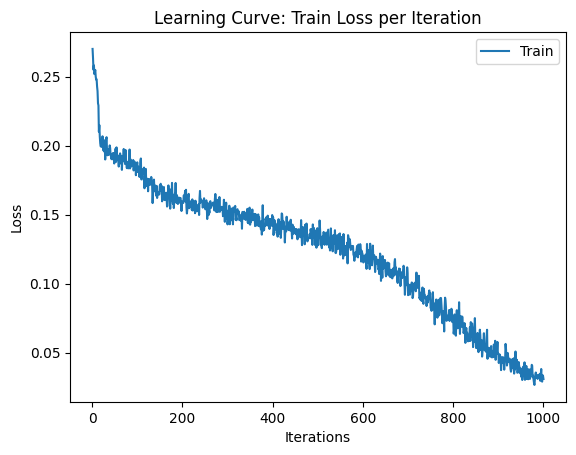

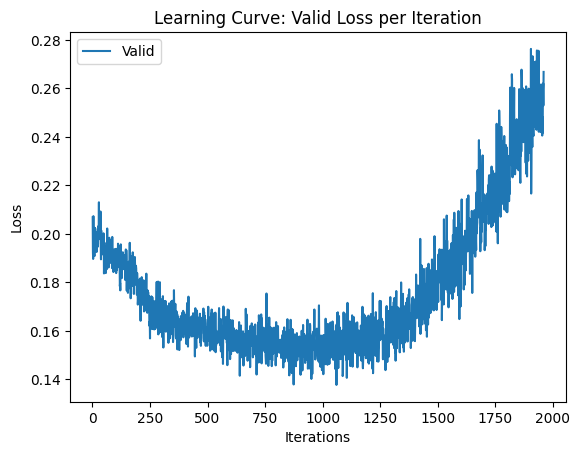

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MusicGenRNN(num_rnn_layers=2)
model.to(device)
# check_point_path = "/content/gdrive/My Drive/University/Year 4/CSC413/Project/check_pts/ckpt-{}.pk"
plot_data = train(model, device, train_set[:500], validation_set, num_epochs=40, batch_size=20, weight_decay=1e-5)
plot_learning_curve(*plot_data)

In [ ]:
weights = torch.load("/content/gdrive/My Drive/University/Year 4/CSC413/Project/friday_model_no_eos_more_data.pk", map_location=torch.device('cpu'))
model.load_state_dict(weights)
# model.load_state_dict(torch.load("/content/gdrive/My Drive/University/Year 4/CSC413/Project/{}.pk".format(NAME HERE)))

In [ ]:
torch.save(model.state_dict(), "/content/gdrive/My Drive/University/Year 4/CSC413/Project/{}.pk".format("NEWFILE"))

# **Sampling/Producing Music**

In [ ]:
def sample_sequence(model, input_seq = None, max_len = 100, temperature = 0.8):
  model.eval()
  inp = torch.Tensor([[128, 0, 0]]).reshape(1,3).float().to(device)
  generated_sequence = []
  hidden = None
  if input_seq is not None:
    out, hidden = model(input_seq.unsqueeze(0), hidden)
  for p in range(max_len):
    output, hidden = model(inp.unsqueeze(0), hidden)

    # Sample from the network as a multinomial distribution
    output_dist = output[0, 0, :129].data.view(-1).div(temperature).exp()
    top_i = int(torch.multinomial(output_dist, 1)[0])
    # Add predicted character to string and use as next input 
    predicted_pitch = [top_i, output[0, 0, 129], output[0, 0, 130]]
    if top_i == 129: break
    generated_sequence.append(predicted_pitch)
    inp = torch.Tensor([[top_i, output[0, 0, 129], output[0, 0, 130]]]).reshape(1, 3).float().to(device)
    print(inp)
  if input_seq is not None:
    return torch.concat((input_seq.cpu(), torch.tensor(generated_sequence).cpu()), dim=0)
  return torch.tensor(generated_sequence)


In [ ]:
inp = torch.Tensor(validation_set[50]).to(device)
gen_seq = sample_sequence(model, max_len=200, temperature=.8, input_seq=inp)

create_midi_file("/content/gdrive/My Drive/University/Year 4/CSC413/Project/currjj2.mid", gen_seq)
create_midi_file("/content/gdrive/My Drive/University/Year 4/CSC413/Project/test.mid", inp)

tensor([[68.0000,  0.2326,  0.2619]], device='cuda:0')
tensor([[60.0000,  0.1668,  0.2550]], device='cuda:0')
tensor([[68.0000,  0.4026,  0.3679]], device='cuda:0')
tensor([[68.0000,  0.1261,  0.2793]], device='cuda:0')
tensor([[60.0000,  0.1193,  0.3203]], device='cuda:0')
tensor([[66.0000,  0.2959,  0.2731]], device='cuda:0')
tensor([[68.0000,  0.1314,  0.2598]], device='cuda:0')
tensor([[63.0000,  0.1765,  0.3381]], device='cuda:0')
tensor([[70.0000,  0.3518,  0.2235]], device='cuda:0')
tensor([[62.0000,  0.0736,  0.2165]], device='cuda:0')
tensor([[61.0000,  0.2175,  0.2343]], device='cuda:0')
tensor([[68.0000,  0.1593,  0.2208]], device='cuda:0')
tensor([[60.0000,  0.2724,  0.1852]], device='cuda:0')
tensor([[63.0000,  0.0979,  0.2194]], device='cuda:0')
tensor([[68.0000,  0.0955,  0.1798]], device='cuda:0')
tensor([[60.0000,  0.1758,  0.1341]], device='cuda:0')
tensor([[68.0000,  0.1230,  0.1606]], device='cuda:0')
tensor([[68.0000,  0.0917,  0.1591]], device='cuda:0')
tensor([[6